# Uniform grating coupler


In [1]:
# basic imports
import numpy as np
import matplotlib.pylab as plt

# tidy3d imports
import tidy3d as td
import tidy3d.web as web


## Problem Setup

In this example, we model a 3D grating coupler in a Silicon on Insulator (SOI) platform.

A basic schematic of the design is shown below.  The simulation is about 19um x 4um x 5um with a wavelength of 1.55um and takes about 1 minute to simulate 10,000 time steps.

In the simulation, we inject a modal source into the waveguide and propagate it towards the grating structure.  The radiation from the grating coupler is then measured with a near field monitor and we use a far field projection to inspect the angular dependence of the radiation.

<img src="img/grating_coupler.png" width=600 alt="Schematic of the grating coupler">

In addition to the uniform grating coupler modeled here, we also studied a [focusing apodized grating coupler](https://www.flexcompute.com/tidy3d/examples/notebooks/FocusedApodGC/) and an [inverse designed compact grating coupler](https://www.flexcompute.com/tidy3d/examples/notebooks/AdjointPlugin6GratingCoupler/) in our case studies. Besides grating couplers, we have also investigated an [inverse taper edge coupler](https://www.flexcompute.com/tidy3d/examples/notebooks/EdgeCoupler/).

If you are new to the finite-difference time-domain (FDTD) method, we highly recommend going through our [FDTD101](https://www.flexcompute.com/fdtd101/) tutorials. 

In [2]:
# basic parameters (note, all length units are microns)
nm = 1e-3
wavelength = 1550 * nm

# grid specification
grid_spec = td.GridSpec.auto(min_steps_per_wvl=20, wavelength=wavelength)

# waveguide
wg_width = 400 * nm
wg_height = 220 * nm
wg_length = 2 * wavelength

# surrounding
sub_height = 2.0
air_height = 2.0
buffer = 0.5 * wavelength

# coupler
cp_width = 4 * wavelength
cp_length = 8 * wavelength
taper_length = 6 * wavelength


In [3]:
# sizes
Lx = buffer + wg_length + taper_length + cp_length
Ly = buffer + cp_width + buffer
Lz = sub_height + wg_height + air_height
sim_size = [Lx, Ly, Lz]

# convenience variables to store center of coupler and waveguide
wg_center_x = +Lx / 2 - buffer - (wg_length + taper_length) / 2
cp_center_x = -Lx / 2 + buffer + cp_length / 2
wg_center_z = -Lz / 2 + sub_height + wg_height / 2
cp_center_z = -Lz / 2 + sub_height + wg_height / 2

# materials
Air = td.Medium(permittivity=1.0)
Si = td.Medium(permittivity=3.47**2)
SiO2 = td.Medium(permittivity=1.44**2)

# source parameters
freq0 = td.C_0 / wavelength
fwidth = freq0 / 10
run_time = 100 / fwidth


## Mode Solve
To determine the pitch of the waveguide for a given design angle, we need to compute the effective index of the waveguide mode being coupled into.  For this, we set up a simple simulation of the coupler region and use the mode solver to get the effective index. We will not run this simulation, we just add a ``ModeMonitor`` object in order to construct and run the mode solver below, and get the effective index of the wide-waveguide region. 

Note: because the simulation is just being used for the mode solver, we can safely ignore the warning about lack of sources.

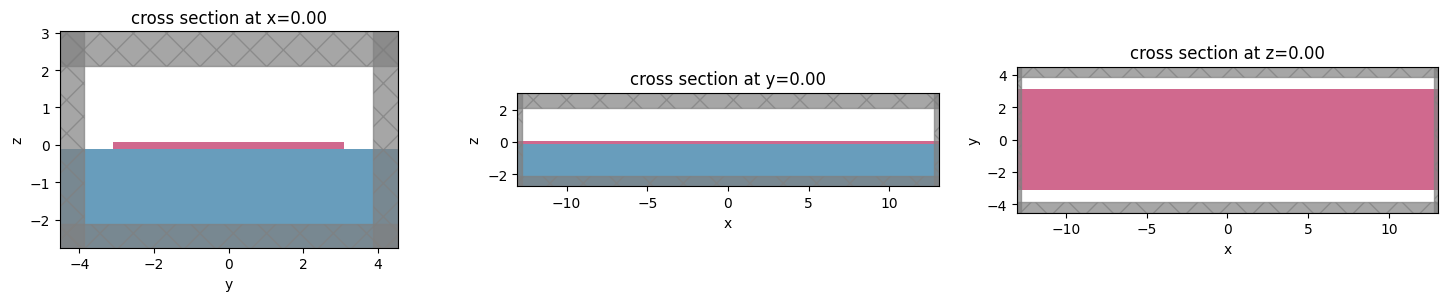

In [4]:
# grating parameters
design_theta_deg = -30
design_theta_rad = np.pi * design_theta_deg / 180
grating_height = 70 * nm

# do a mode solve to get neff of the coupler

sub = td.Structure(
    geometry=td.Box(center=[0, 0, -Lz / 2], size=[td.inf, td.inf, 2 * sub_height]),
    medium=SiO2,
    name="substrate",
)

cp = td.Structure(
    geometry=td.Box(
        center=[0, 0, cp_center_z - grating_height / 4],
        size=[td.inf, cp_width, wg_height - grating_height / 2],
    ),
    medium=Si,
    name="coupler",
)

mode_plane = td.Box(center=(0, 0, 0), size=(0, 8 * cp_width, 8 * wg_height))


sim = td.Simulation(
    size=sim_size,
    grid_spec=grid_spec,
    structures=[sub, cp],
    sources=[],
    monitors=[],
    boundary_spec=td.BoundarySpec.all_sides(boundary=td.PML()),
    run_time=1e-12,
)

f, (ax1, ax2, ax3) = plt.subplots(1, 3, tight_layout=True, figsize=(15, 3))
sim.plot(x=0, ax=ax1)
sim.plot(y=0, ax=ax2)
sim.plot(z=0, ax=ax3)
plt.show()


## Compute Effective index for Grating Pitch Design

In [5]:
from tidy3d.plugins.mode import ModeSolver

ms = ModeSolver(
    simulation=sim, plane=mode_plane, mode_spec=td.ModeSpec(), freqs=[freq0]
)
mode_output = ms.solve()


[12:53:09] WARNING: Use the remote mode solver with subpixel  ]8;id=445083;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/plugins/mode/mode_solver.py\mode_solver.py]8;;\:]8;id=140517;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/plugins/mode/mode_solver.py#141\141]8;;\
           averaging for better accuracy through                                
           'tidy3d.plugins.mode.web.run(...)'.                                  

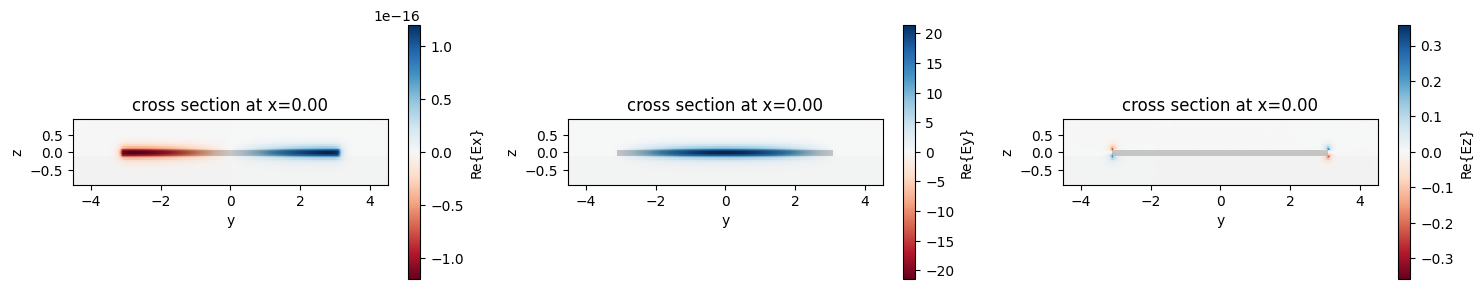

In [6]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, tight_layout=True, figsize=(15, 3))
ms.plot_field("Ex", val="real", robust=False, ax=ax1)
ms.plot_field("Ey", val="real", robust=False, ax=ax2)
ms.plot_field("Ez", val="real", robust=False, ax=ax3)
plt.show()


In [7]:
neff = float(mode_output.n_eff)
print(f"effective index = {neff:.4f}")


effective index = 2.6886


## Create Simulation
Now we set up the grating coupler to simulate in Tidy3D.

In [8]:
# gratings
pitch = wavelength / (neff - np.sin(abs(design_theta_rad)))
grating_length = pitch / 2.0
num_gratings = int(cp_length / pitch)

sub = td.Structure(
    geometry=td.Box(
        center=[0, 0, -Lz / 2],
        size=[td.inf, td.inf, 2 * sub_height],
    ),
    medium=SiO2,
    name="substrate",
)

wg = td.Structure(
    geometry=td.Box(
        center=[wg_center_x, 0, wg_center_z],
        size=[buffer + wg_length + taper_length + cp_length / 2, wg_width, wg_height],
    ),
    medium=Si,
    name="waveguide",
)

cp = td.Structure(
    geometry=td.Box(
        center=[cp_center_x, 0, cp_center_z],
        size=[cp_length, cp_width, wg_height],
    ),
    medium=Si,
    name="coupler",
)

tp = td.Structure(
    geometry=td.PolySlab(
        vertices=[
            [cp_center_x + cp_length / 2 + taper_length, +wg_width / 2],
            [cp_center_x + cp_length / 2 + taper_length, -wg_width / 2],
            [cp_center_x + cp_length / 2, -cp_width / 2],
            [cp_center_x + cp_length / 2, +cp_width / 2],
        ],
        slab_bounds=(wg_center_z - wg_height / 2, wg_center_z + wg_height / 2),
        axis=2,
    ),
    medium=Si,
    name="taper",
)

grating_left_x = cp_center_x - cp_length / 2
gratings = [
    td.Structure(
        geometry=td.Box(
            center=[
                grating_left_x + (i + 0.5) * pitch,
                0,
                cp_center_z + wg_height / 2 - grating_height / 2,
            ],
            size=[grating_length, cp_width, grating_height],
        ),
        medium=Air,
        name=f"{i}th_grating",
    )
    for i in range(num_gratings)
]


In [9]:
# distance to near field monitor
nf_offset = 50 * nm

plane_monitor = td.FieldMonitor(
    center=[0, 0, cp_center_z],
    size=[td.inf, td.inf, 0],
    freqs=[freq0],
    name="full_domain_fields",
)

rad_monitor = td.FieldMonitor(
    center=[0, 0, 0], size=[td.inf, 0, td.inf], freqs=[freq0], name="radiated_fields"
)

near_field_monitor = td.FieldMonitor(
    center=[cp_center_x, 0, cp_center_z + wg_height / 2 + nf_offset],
    size=[td.inf, td.inf, 0],
    freqs=[freq0],
    name="radiated_near_fields",
)


[12:53:12] WARNING: Default value for the field monitor           ]8;id=64159;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/components/monitor.py\monitor.py]8;;\:]8;id=342956;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/components/monitor.py#261\261]8;;\
           'colocate' setting has changed to 'True' in Tidy3D                   
           2.4.0. All field components will be colocated to the                 
           grid boundaries. Set to 'False' to get the raw fields                
           on the Yee grid instead.                                             

           WARNING: Default value for the field monitor           ]8;id=114265;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/components/monitor.py\monitor.py]8;;\:]8;id=408655;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/components/monitor.py#261\261]8;;\
           'colocate' setting has changed to 'True' in Tidy3D                   
           2.4.0. All field components will be colocated to the                 
           grid boundaries. Set to 'False' to get the raw fields                
           on the Yee grid instead.                                             

           WARNING: Default value for the field monitor           ]8;id=193636;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/components/monitor.py\monitor.py]8;;\:]8;id=303879;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/components/monitor.py#261\261]8;;\
           'colocate' setting has changed to 'True' in Tidy3D                   
           2.4.0. All field components will be colocated to the                 
           grid boundaries. Set to 'False' to get the raw fields                
           on the Yee grid instead.                                             

In [10]:
sim = td.Simulation(
    size=sim_size,
    grid_spec=grid_spec,
    structures=[sub, wg, cp, tp] + gratings,
    sources=[],
    monitors=[plane_monitor, rad_monitor, near_field_monitor],
    run_time=run_time,
    boundary_spec=td.BoundarySpec.all_sides(boundary=td.PML()),
)


### Make Modal Source

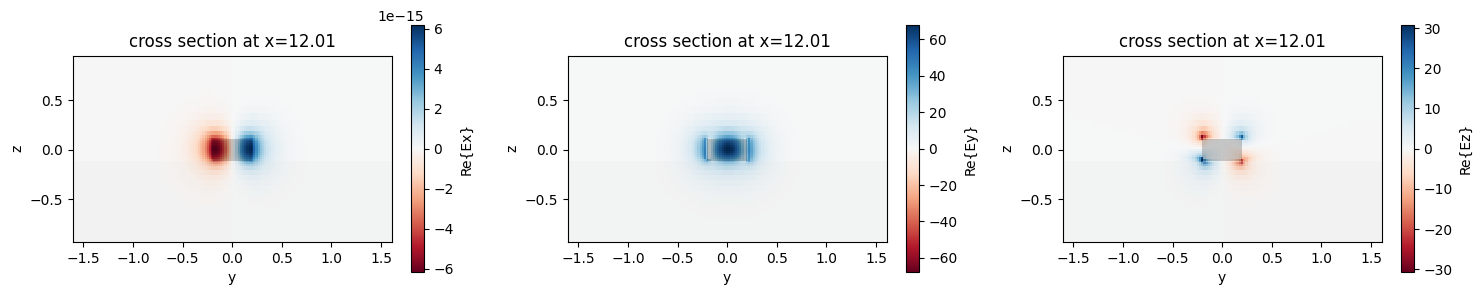

In [11]:
source_plane = td.Box(
    center=[Lx / 2 - buffer, 0, cp_center_z],
    size=[0, 8 * wg_width, 8 * wg_height],
)

ms = ModeSolver(
    simulation=sim, plane=source_plane, mode_spec=td.ModeSpec(), freqs=[freq0]
)
mode_output = ms.solve()

f, (ax1, ax2, ax3) = plt.subplots(1, 3, tight_layout=True, figsize=(15, 3))
ms.plot_field("Ex", val="real", robust=False, ax=ax1)
ms.plot_field("Ey", val="real", robust=False, ax=ax2)
ms.plot_field("Ez", val="real", robust=False, ax=ax3)
plt.show()


In [12]:
source_time = td.GaussianPulse(freq0=freq0, fwidth=fwidth)
mode_src = ms.to_source(mode_index=0, direction="-", source_time=source_time)
sim = sim.copy(update={"sources": [mode_src]})


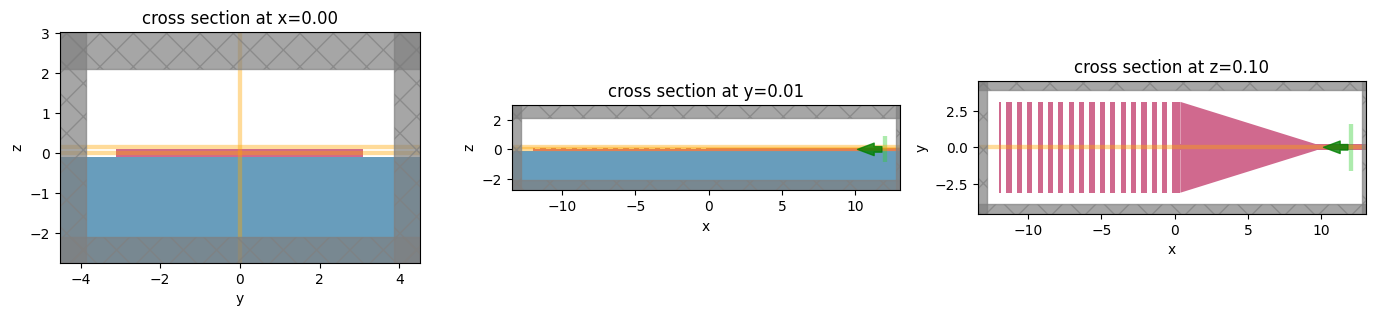

In [13]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, tight_layout=True, figsize=(14, 3))
sim.plot(x=0, ax=ax1)
sim.plot(y=0.01, ax=ax2)
sim.plot(z=0.1, ax=ax3)
plt.show()


In [14]:
mode_src.help()


╭───────────────────────────────── <class 'tidy3d.components.source.ModeSource'> ─────────────────────────────────╮
│ Injects current source to excite modal profile on finite extent plane.                                          │
│                                                                                                                 │
│ ╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────╮ │
│ │ ModeSource(                                                                                                 │ │
│ │ │   type='ModeSource',                                                                                      │ │
│ │ │   center=(12.012500000000001, 0.0, -3.191891195797325e-16),                                               │ │
│ │ │   size=(0.0, 3.2, 1.76),                                                                                  │ │
│ │ │   source_time=GaussianPulse(                                                                              │ │
│ │ │   │   amplitude=1.0,                                                                                      │ │
│ │ │   │   phase=0.0,                                                                                          │ │
│ │ │   │   type='GaussianPulse',                                                                               │ │
│ │ │   │   freq0=193414489032258.06,                                                                           │ │
│ │ │   │   fwidth=19341448903225.805,                                                                          │ │
│ │ │   │   offset=5.0,                                                                                         │ │
│ │ │   │   remove_dc_component=True                                                                            │ │
│ │ │   ),                                                                                                      │ │
│ │ │   name=None,                                                                                              │ │
│ │ │   num_freqs=1,                                                                                            │ │
│ │ │   direction='-',                                                                                          │ │
│ │ │   mode_spec=ModeSpec(                                                                                     │ │
│ │ │   │   num_modes=1,                                                                                        │ │
│ │ │   │   target_neff=None,                                                                                   │ │
│ │ │   │   num_pml=(0, 0),                                                                                     │ │
│ │ │   │   filter_pol=None,                                                                                    │ │
│ │ │   │   angle_theta=0.0,                                                                                    │ │
│ │ │   │   angle_phi=0.0,                                                                                      │ │
│ │ │   │   precision='single',                                                                                 │ │
│ │ │   │   bend_radius=None,                                                                                   │ │
│ │ │   │   bend_axis=None,                                                                                     │ │
│ │ │   │   track_freq='central',                                                                               │ │
│ │ │   │   group_index_step=False,                                                                             │ │
│ │ │   │   type='ModeSpec'                                                                                     │ │
│ │ │   ),                                                                                                      │ │
│ │ │   mode_index=0                                    

## Run Simulation

Run the simulation and plot the field patterns

In [15]:
# create a project, upload to our server to run
job = web.Job(simulation=sim, task_name="grating_coupler", verbose=True)
sim_data = job.run(path="data/grating_coupler.hdf5")
print(sim_data.log)


[12:53:14] Created task 'grating_coupler' with task_id             ]8;id=621353;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=58969;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#188\188]8;;\
           'fdve-2795c3d8-1d63-4723-9b42-2cd49242b72cv1'.                       

           View task using web UI at                               ]8;id=211250;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=78337;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#190\190]8;;\
           ]8;id=516472;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2795c3d8-1d63-4723-9b42-2cd49242b72cv1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=744552;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2795c3d8-1d63-4723-9b42-2cd49242b72cv1\taskId]8;;\]8;id=516472;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2795c3d8-1d63-4723-9b42-2cd49242b72cv1\=]8;;\]8;id=287146;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2795c3d8-1d63-4723-9b42-2cd49242b72cv1\fdve]8;;\]8;id=516472;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2795c3d8-1d63-4723-9b42-2cd49242b72cv1\-]8;;\              
           ]8;id=516472;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2795c3d8-1d63-4723-9b42-2cd49242b72cv1\2795c3d8-1d63-4723-9b42-2cd49242b72cv1']8;;\.                             

Output()

[12:53:15] status = queued                                         ]8;id=9905;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=956396;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#361\361]8;;\

Output()

[12:53:23] status = preprocess                                     ]8;id=572812;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=777809;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#355\355]8;;\

[12:53:28] Maximum FlexCredit cost: 1.621. Use                     ]8;id=792244;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=968336;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#341\341]8;;\
           'web.real_cost(task_id)' to get the billed FlexCredit                
           cost after a simulation run.                                         

           starting up solver                                      ]8;id=464106;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=116081;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#377\377]8;;\

           running solver                                          ]8;id=772209;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=875286;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#386\386]8;;\

           To cancel the simulation, use 'web.abort(task_id)' or   ]8;id=250092;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=674679;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#387\387]8;;\
           'web.delete(task_id)' or abort/delete the task in the                
           web UI. Terminating the Python script will not stop the              
           job running on the cloud.                                            

Output()

[12:58:21] early shutoff detected, exiting.                        ]8;id=801434;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=147036;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#404\404]8;;\

           status = postprocess                                    ]8;id=253317;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=383481;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#419\419]8;;\

Output()

[12:58:40] status = success                                        ]8;id=340371;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=794090;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#426\426]8;;\

Output()

[12:58:43] loading SimulationData from data/grating_coupler.hdf5   ]8;id=320999;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=92135;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#590\590]8;;\

Simulation domain Nx, Ny, Nz: [1157, 334, 102]
Applied symmetries: (0, 0, 0)
Number of computational grid points: 4.0500e+07.
Using subpixel averaging: True
Number of time steps: 1.3518e+05
Automatic shutoff factor: 1.00e-05
Time step (s): 3.8247e-17


Compute source modes time (s):     0.4286
Compute monitor modes time (s):    0.0030
Rest of setup time (s):            5.6429

Running solver for 135181 time steps...
- Time step   1076 / time 4.12e-14s (  0 % done), field decay: 1.00e+00
- Time step   5407 / time 2.07e-13s (  4 % done), field decay: 1.00e+00
- Time step  10814 / time 4.14e-13s (  8 % done), field decay: 1.75e-02
- Time step  16221 / time 6.20e-13s ( 12 % done), field decay: 3.27e-03
- Time step  21628 / time 8.27e-13s ( 16 % done), field decay: 2.48e-04
- Time step  27036 / time 1.03e-12s ( 20 % done), field decay: 6.94e-05
- Time step  32443 / time 1.24e-12s ( 24 % done), field decay: 2.10e-05
- Time step  37850 / time 1.45e-12s ( 28 % done), field decay: 6.41e-06
Fiel

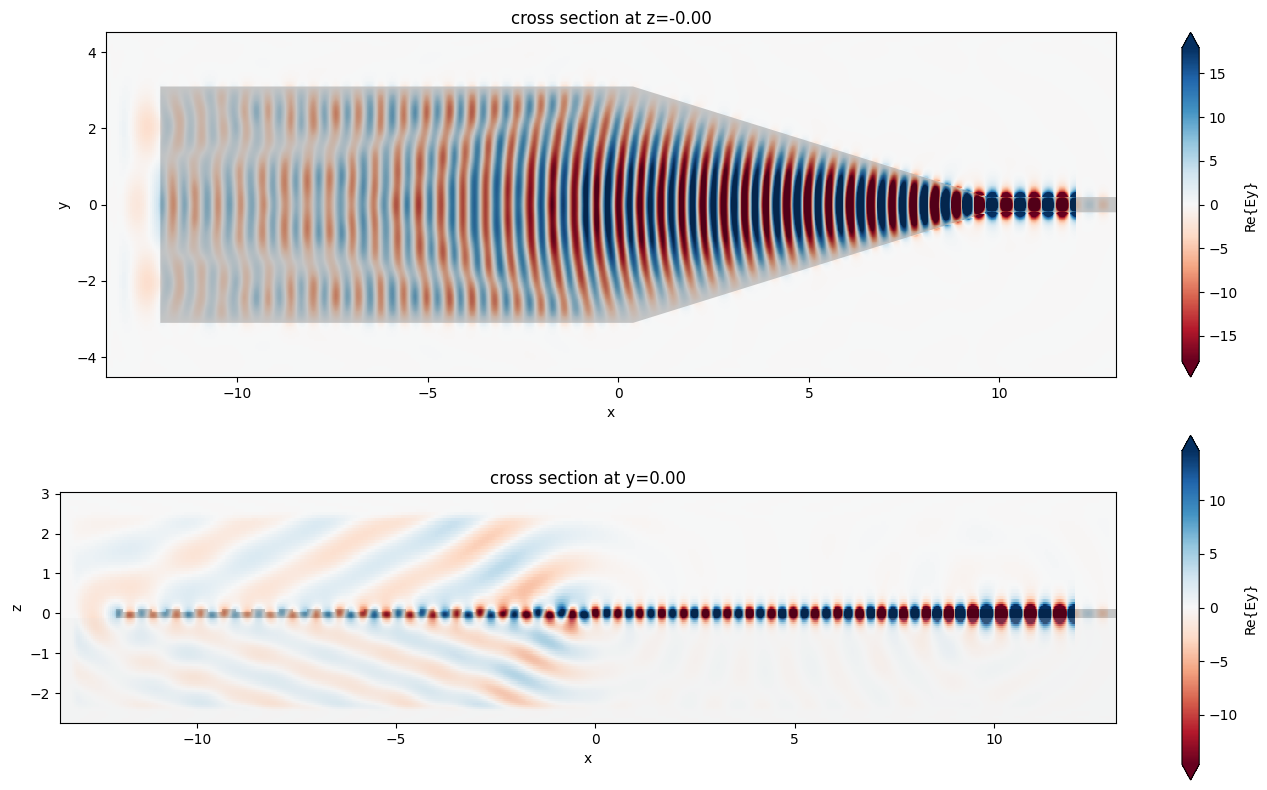

In [16]:
fig, (ax1, ax2) = plt.subplots(2, 1, tight_layout=True, figsize=(14, 8))
sim_data.plot_field("full_domain_fields", "Ey", f=freq0, ax=ax1)
sim_data.plot_field("radiated_fields", "Ey", f=freq0, ax=ax2)
plt.show()


## Far Field Projection
Now we use the `Tidy3D`'s [FieldProjector](../_autosummary/tidy3d.FieldProjector.html) to compute the anglular dependence of the far field scattering based on the near field monitor.

In [17]:
# create range of angles to probe (note: polar coordinates, theta = 0 corresponds to vertical (z axis))
num_angles = 1101
thetas = np.linspace(-np.pi / 2, np.pi / 2, num_angles)

# make a near-to-far monitor specifying the observation angles and frequencies of interest
monitor_n2f = td.FieldProjectionAngleMonitor(
    center=near_field_monitor.center,
    size=near_field_monitor.size,
    normal_dir="+",
    freqs=[freq0],
    theta=thetas,
    phi=[0.0],
    name="n2f",
)

# make a near field to far field projector with the near field monitor data
near_field_surface = td.FieldProjectionSurface(
    monitor=near_field_monitor, normal_dir="+"
)
n2f = td.FieldProjector(sim_data=sim_data, surfaces=[near_field_surface])

# compute the far_fields
far_fields = n2f.project_fields(monitor_n2f)

# Compute the scattered cross section
Ps = np.abs(far_fields.radar_cross_section.sel(f=freq0).values[0, ...])


[12:58:52] WARNING: Colocating data that has already been          ]8;id=505792;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/components/data/dataset.py\dataset.py]8;;\:]8;id=124304;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/components/data/dataset.py#79\79]8;;\
           colocated during the solver run. For most accurate                   
           results when colocating to custom coordinates set                    
           'Monitor.colocate' to 'False' to use the raw data on                 
           the Yee grid and avoid double interpolation. Note: the               
           default value was changed to 'True' in Tidy3D version                
           2.4.0.                                                               

Output()

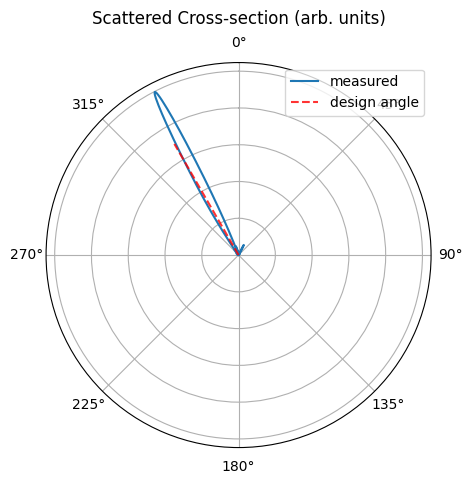

In [18]:
# plot the angle dependence
fig, ax = plt.subplots(subplot_kw={"projection": "polar"}, figsize=(5, 5))
ax.plot(thetas, Ps, label="measured")
ax.plot(
    [design_theta_rad, design_theta_rad],
    [0, np.max(Ps) * 0.7],
    "r--",
    alpha=0.8,
    label="design angle",
)
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
ax.set_yticklabels([])
ax.set_title("Scattered Cross-section (arb. units)", va="bottom")
plt.legend()
plt.show()


In [19]:
print(f"expect angle of {(design_theta_rad * 180 / np.pi):.2f} degrees")
i_max = np.argmax(Ps)
print(f"got maximum angle of {(thetas[i_max] * 180 / np.pi):.2f} degrees")


expect angle of -30.00 degrees
got maximum angle of -27.16 degrees


The agreement between the target angle and the actual emission angle of the coupler is good. The small difference comes from the fact that the design is very sensitive to the value of the effective index that we use in the coupler region, and that value depends on which waveguide height we pick in that region: the one with the grating comb, or without. In our setup, we used a thickness that is at the mid-point, but this is a heuristic choice which results in the small final mismatch in angles observed here.

## Gaussian beam into the coupler

We can also run the coupler in the opposite way, injecting a Gaussian beam from above and monitoring the transmission into the waveguide. We will use the measured angle rather than the design angle to see the highest in-coupling efficiency that we can obtain.

In [20]:
gaussian_beam = td.GaussianBeam(
    size=(td.inf, td.inf, 0),
    center=[-8, 0, 2],
    source_time=td.GaussianPulse(freq0=freq0, fwidth=fwidth),
    angle_theta=27.16 * np.pi / 180,
    angle_phi=np.pi,
    direction="-",
    waist_radius=2,
    pol_angle=np.pi / 2,
)

mode_mon = ms.to_monitor(freqs=[freq0], name="coupled")

flux_mon = td.FluxMonitor(
    size=mode_mon.size,
    center=mode_mon.center,
    freqs=[freq0],
    name="flux",
)


sim2 = td.Simulation(
    size=sim_size,
    grid_spec=grid_spec,
    structures=[sub, wg, cp, tp] + gratings,
    sources=[gaussian_beam],
    monitors=[plane_monitor, rad_monitor, mode_mon, flux_mon],
    run_time=run_time,
    boundary_spec=td.BoundarySpec.all_sides(boundary=td.PML()),
)


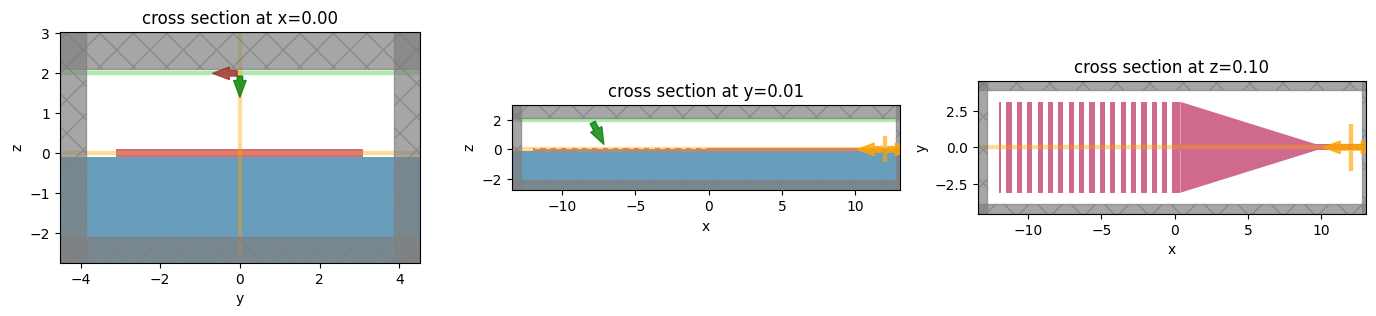

In [21]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, tight_layout=True, figsize=(14, 3))
sim2.plot(x=0, ax=ax1)
sim2.plot(y=0.01, ax=ax2)
sim2.plot(z=0.1, ax=ax3)
plt.show()


In [22]:
job2 = web.Job(simulation=sim2, task_name="grating_coupler_beam", verbose=True)
sim_data2 = job2.run(path="data/grating_coupler.hdf5")
print(sim_data2.log)


[12:58:53] Created task 'grating_coupler_beam' with task_id        ]8;id=196904;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=781094;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#188\188]8;;\
           'fdve-9ef3067f-891f-472c-a912-d99b40195c73v1'.                       

           View task using web UI at                               ]8;id=667030;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=662784;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#190\190]8;;\
           ]8;id=860892;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9ef3067f-891f-472c-a912-d99b40195c73v1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=252699;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9ef3067f-891f-472c-a912-d99b40195c73v1\taskId]8;;\]8;id=860892;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9ef3067f-891f-472c-a912-d99b40195c73v1\=]8;;\]8;id=330265;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9ef3067f-891f-472c-a912-d99b40195c73v1\fdve]8;;\]8;id=860892;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9ef3067f-891f-472c-a912-d99b40195c73v1\-]8;;\              
           ]8;id=860892;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9ef3067f-891f-472c-a912-d99b40195c73v1\9ef3067f-891f-472c-a912-d99b40195c73v1']8;;\.                             

Output()

[12:58:59] status = queued                                         ]8;id=287040;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=673157;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#361\361]8;;\

Output()

[12:59:30] status = preprocess                                     ]8;id=947663;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=898341;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#355\355]8;;\

[12:59:35] Maximum FlexCredit cost: 1.620. Use                     ]8;id=572054;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=346265;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#341\341]8;;\
           'web.real_cost(task_id)' to get the billed FlexCredit                
           cost after a simulation run.                                         

           starting up solver                                      ]8;id=638113;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=745996;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#377\377]8;;\

           running solver                                          ]8;id=796622;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=554773;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#386\386]8;;\

           To cancel the simulation, use 'web.abort(task_id)' or   ]8;id=146712;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=97091;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#387\387]8;;\
           'web.delete(task_id)' or abort/delete the task in the                
           web UI. Terminating the Python script will not stop the              
           job running on the cloud.                                            

Output()

[13:00:53] early shutoff detected, exiting.                        ]8;id=516128;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=131019;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#404\404]8;;\

[13:00:54] status = postprocess                                    ]8;id=300050;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=357838;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#419\419]8;;\

Output()

[13:00:58] status = success                                        ]8;id=986991;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=641749;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#426\426]8;;\

Output()

[13:01:01] loading SimulationData from data/grating_coupler.hdf5   ]8;id=614541;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=606931;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#590\590]8;;\

Simulation domain Nx, Ny, Nz: [1157, 334, 102]
Applied symmetries: (0, 0, 0)
Number of computational grid points: 4.0500e+07.
Using subpixel averaging: True
Number of time steps: 1.3518e+05
Automatic shutoff factor: 1.00e-05
Time step (s): 3.8247e-17


Compute source modes time (s):     1.3101
Compute monitor modes time (s):    0.4805
Rest of setup time (s):            16.7477

Running solver for 135181 time steps...
- Time step   1076 / time 4.12e-14s (  0 % done), field decay: 1.00e+00
- Time step   5407 / time 2.07e-13s (  4 % done), field decay: 9.70e-03
- Time step  10814 / time 4.14e-13s (  8 % done), field decay: 1.59e-03
- Time step  16221 / time 6.20e-13s ( 12 % done), field decay: 2.76e-05
- Time step  21628 / time 8.27e-13s ( 16 % done), field decay: 5.84e-06
Field decay smaller than shutoff factor, exiting solver.

Solver time (s):                   57.5160
Data write time (s):               0.0475



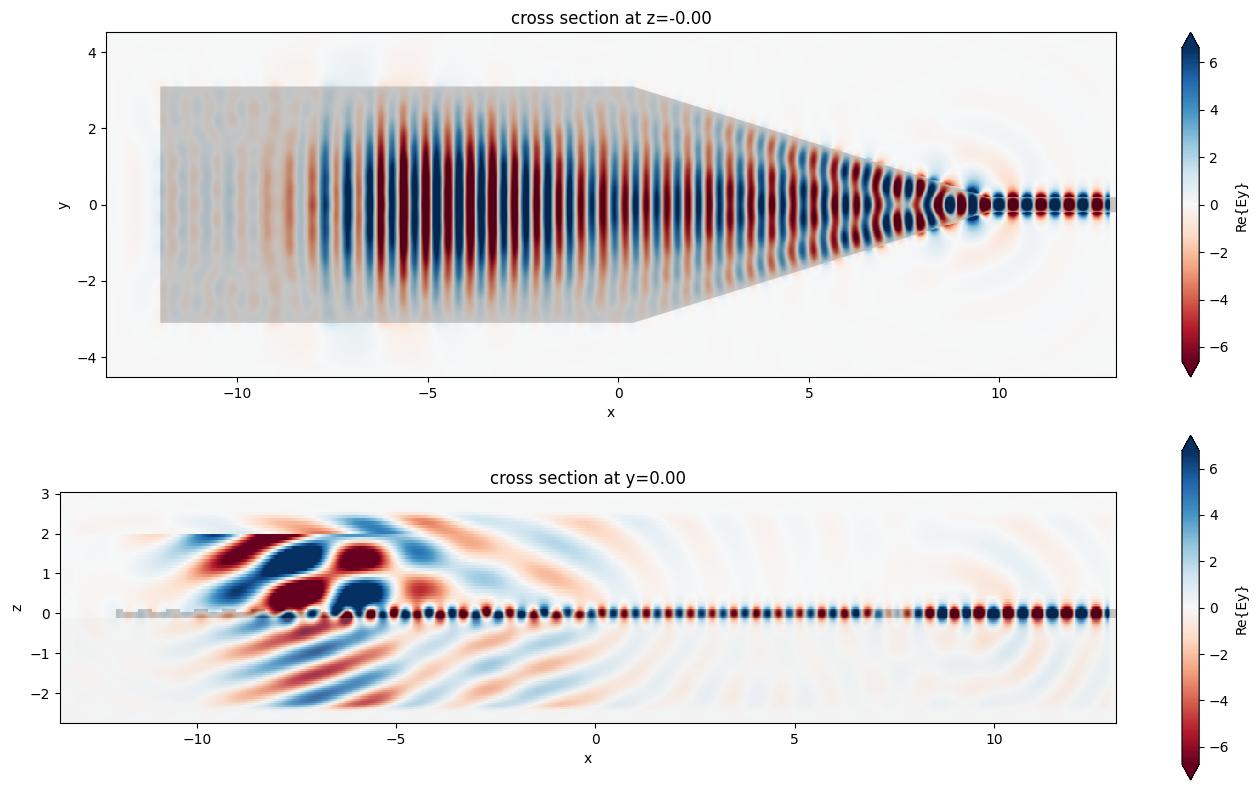

In [23]:
fig, (ax1, ax2) = plt.subplots(2, 1, tight_layout=True, figsize=(14, 8))
sim_data2.plot_field("full_domain_fields", "Ey", f=freq0, ax=ax1)
sim_data2.plot_field("radiated_fields", "Ey", f=freq0, ax=ax2)
plt.show()


In [24]:
flux = sim_data2["flux"].flux
print(f"flux in waveguide / flux in = {float(flux):.4f} ")


flux in waveguide / flux in = 0.0487 


The coupler has close to 5% in-coupling efficiency, and we did not put any effort into optimizing it beyond just defining the grating pitch to target the correct angle!